Multi Step Forecast with ARIMA.

In [8]:
# import libraries
from datetime import datetime, timedelta
import dateutil.parser
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import pandas as pd
import pickle
from statsmodels.tsa.arima_model import ARIMA

In [9]:
def place_value(number): 
    """Changes number to a readable number with ','s for 000s'"""
    
    number = int(number)
    
    return ("{:,}".format(number))


In [10]:
def forecast_multi_step(df, arg_dict):
    """Create a forecast multiple time periods into the future"""
    
    # load dataset
    series = df[arg_dict['dependent_variable']]
    X = series.values
    
    # fit model
    model = ARIMA(X, order=(arg_dict['best_cfg'])) 
    model_fit = model.fit(disp=0)
    
    # Create time period to report on
    start = df.index[-1]
    end = pd.to_datetime(arg_dict['date'], infer_datetime_format=True)
    steps = end - start
    steps = (steps.days) + 1 # Add 1 day

    # Fit the out of sample
    forecast = model_fit.forecast(steps=steps)[0]

    # Add the bias
    predictions = []
    for yhat in forecast:

        yhat = arg_dict['bias'] + yhat
        yhat = int(yhat)
        predictions.append(yhat)

    # Create a df for reporting
    # Create a date_range index
    start = df.index[-1]
    end = start + timedelta(days=steps-1)

    # Create the df
    forecast_df = pd.DataFrame({arg_dict['dependent_variable']: predictions}, index=pd.date_range(start=start, end=end))

    # Shift Deaths by one day to make it lineup correctly with the date. 
    forecast_df[arg_dict['dependent_variable']] = forecast_df[arg_dict['dependent_variable']].shift(1)
    forecast_df = forecast_df[1:]
    
    return forecast_df


In [11]:
def forecast(forecast_df, arg_dict):
    """Print out the prediction in a readable format"""
    
    # Some countries are flattening the curve. As a result ARIMA will forecast fewer 'Deaths'.
    # Then the cumulative numbers start decreasing and will go negative. Lets catch that here.
    
    # Just want a normal integer index
    forecast_df.reset_index(inplace=True)
    forecast_df.rename(columns={'index': 'Date_'}, inplace=True)

    # Get max values
    max_forecast = forecast_df[arg_dict['dependent_variable']].max()
    idx_max = forecast_df[arg_dict['dependent_variable']].idxmax()
    last_forecast = forecast_df[arg_dict['dependent_variable']].iloc[-1]

    if last_forecast < max_forecast:
        # Truncate forecast_df
        forecast_df = forecast_df.loc[:idx_max+1]
    else:
        pass

    predicted = place_value(int(forecast_df[arg_dict['dependent_variable']].iloc[-1]))
    forecast_date = forecast_df['Date_'].iloc[-1]
    print(f'The {arg_dict["place"]} prediction is for {predicted} cumulative \
{arg_dict["dependent_variable"]} to occur by {forecast_date}')

    # Make Date_ the index again for plotting purposes
    forecast_df.set_index('Date_', drop='Date_', inplace=True)

    return forecast_df
          

In [12]:
def plot_multi_step_forecast(forecast_df, arg_dict):
    """Plot the multi step forecast"""

    # Assemble title
    start = forecast_df.index[0].strftime('%Y-%m-%d')
    end = forecast_df.index[-1].strftime('%Y-%m-%d')
    title = ('Forecast Cumulative {} for {} From {} to {}').format(
        arg_dict['dependent_variable'], arg_dict['place'], start, end)
    plt.title(title)

    # Create x and y axis labels
    plt.xlabel('Date')
    ylabel_ = ('Cumulative {}').format(arg_dict['dependent_variable'])
    plt.ylabel(ylabel_)

    # Create plot
    plt.plot(arg_dict['dependent_variable'], data=forecast_df, linewidth=4, 
             label=arg_dict['dependent_variable'])
    plt.legend()
    plt.savefig(r'pics/' + arg_dict['place'] + '_prediction.png');
    

In [13]:
def driver(df, arg_dict):
    """driver function for plot, save, forecast"""
    
    # Run forecast into the future
    forecast_df = forecast_multi_step(df, arg_dict)
    
    # Report on results
    forecast_df = forecast(forecast_df, arg_dict)
    
    # Plot results
    plot_multi_step_forecast(forecast_df, arg_dict)
    
    return forecast_df


(97,)
The USA prediction is for 330,075 cumulative Deaths to occur by 2020-12-31 00:00:00


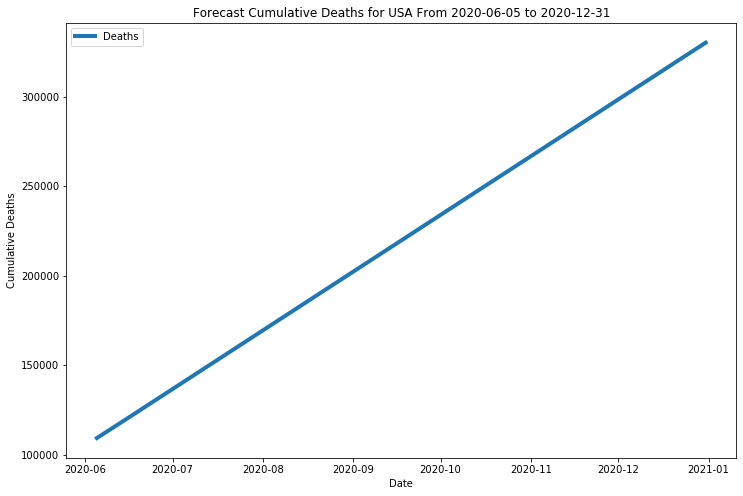

In [14]:
if __name__ == '__main__':
    
    # Prepare arguments for driver
    with open('arg_dict.pickle', 'rb') as handle:
        arg_dict = pickle.load(handle)
    
    df = pd.read_csv('df.csv', parse_dates=True, index_col='Date_')
    
    # Start driver
    forecast_df = driver(df, arg_dict) 
    